# <span style="color:#006400">1 этап: Предобработка данных</span>

## <span style="color:#006400">Подключение библиотек</span>

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import re
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from ydata_profiling import ProfileReport

## <span style="color:#006400">Путь до папки </span>

In [75]:
current_dir = os.getcwd()
print(current_dir)
PATH_OUT = current_dir

df  = pd.read_csv(PATH_OUT+"//csv/rides.csv", 
                 sep=',', encoding='utf-8', decimal=',')
df2 = pd.read_csv(PATH_OUT+"//csv/weather.csv", 
                 sep=',', encoding='utf-8', decimal=',')

C:\Users\mailm\Yandex_AD_scooters\Jupyter notebooks


## <span style="color:#006400">Полезные функции для работы  </span>

In [76]:
#Преобразует числовой столбец, удаляя дробную часть и NaN, приводя к целым числам
def convert_id_column(df, column='Distance'):
    df = df.copy()
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    df[column] = df[column].str.replace('.0$', '', regex=True) 
    df[column] = df[column].str.replace('nan', '', regex=True)
    df[column] = pd.to_numeric(df[column], downcast='integer')
    return df

df = convert_id_column(df)

In [77]:
#Вычисляет длительность сессии между 'Start Date' и 'End Date' в формате HH:MM:SS и дополнительно в минутах
def calculate_session_time(df):
    df = df.copy()
    df['Start Date'] = pd.to_datetime(df['Start Date'])
    df['End Date'] = pd.to_datetime(df['End Date'])
    df['Session Time'] = df['End Date'] - df['Start Date']
    df['Session Time'] = df['Session Time'].apply(
        lambda x: str(x).split()[-1] if 'days' in str(x) else str(x)
    )
    df['Session Time (minutes)'] = pd.to_timedelta(df['Session Time']).dt.total_seconds() / 60
    return df

df = calculate_session_time(df)
df.to_csv("datafrem_data.csv")  

In [78]:
def clean_data_with_threshold(df, variable, threshold, flag):
    """
    Очищает DataFrame, удаляя значения в указанной переменной, которые находятся за пределами заданного порога.
    Создает boxplot до и после очистки.

    Args:
        df (pd.DataFrame): Входной DataFrame.
        variable (str): Название столбца для очистки.
        threshold (float): Пороговое значение.
        flag (str):  Если 'below', удаляет значения меньше порога.
                     Если 'above', удаляет значения больше порога.
                     Если 'both', удаляет значения как меньше, так и больше порога (нужен кортеж из двух значений).

    Returns:
        pd.DataFrame: Очищенный DataFrame.
    """

    # Boxplot до очистки
    plot_numeric_boxplots(df)

    # Очистка данных
    if flag == 'below':
        cleaned_df = df[df[variable] >= threshold].copy()  # Используем .copy(), чтобы избежать предупреждения SettingWithCopyWarning
    elif flag == 'above':
        cleaned_df = df[df[variable] <= threshold].copy()  # Используем .copy(), чтобы избежать предупреждения SettingWithCopyWarning
    elif flag == 'both':
        cleaned_df = df[(df[variable] >= threshold[0]) & (df[variable] <= threshold[1])].copy()  # Используем .copy(), чтобы избежать предупреждения SettingWithCopyWarning
    else:
        raise ValueError("Недопустимое значение флага. Должно быть 'below', 'above' или 'both'.")


    # Boxplot после очистки
    plot_numeric_boxplots(cleaned_df)
    
    return cleaned_df

## <span style="color:#006400">Графики для просмотра данных </span>

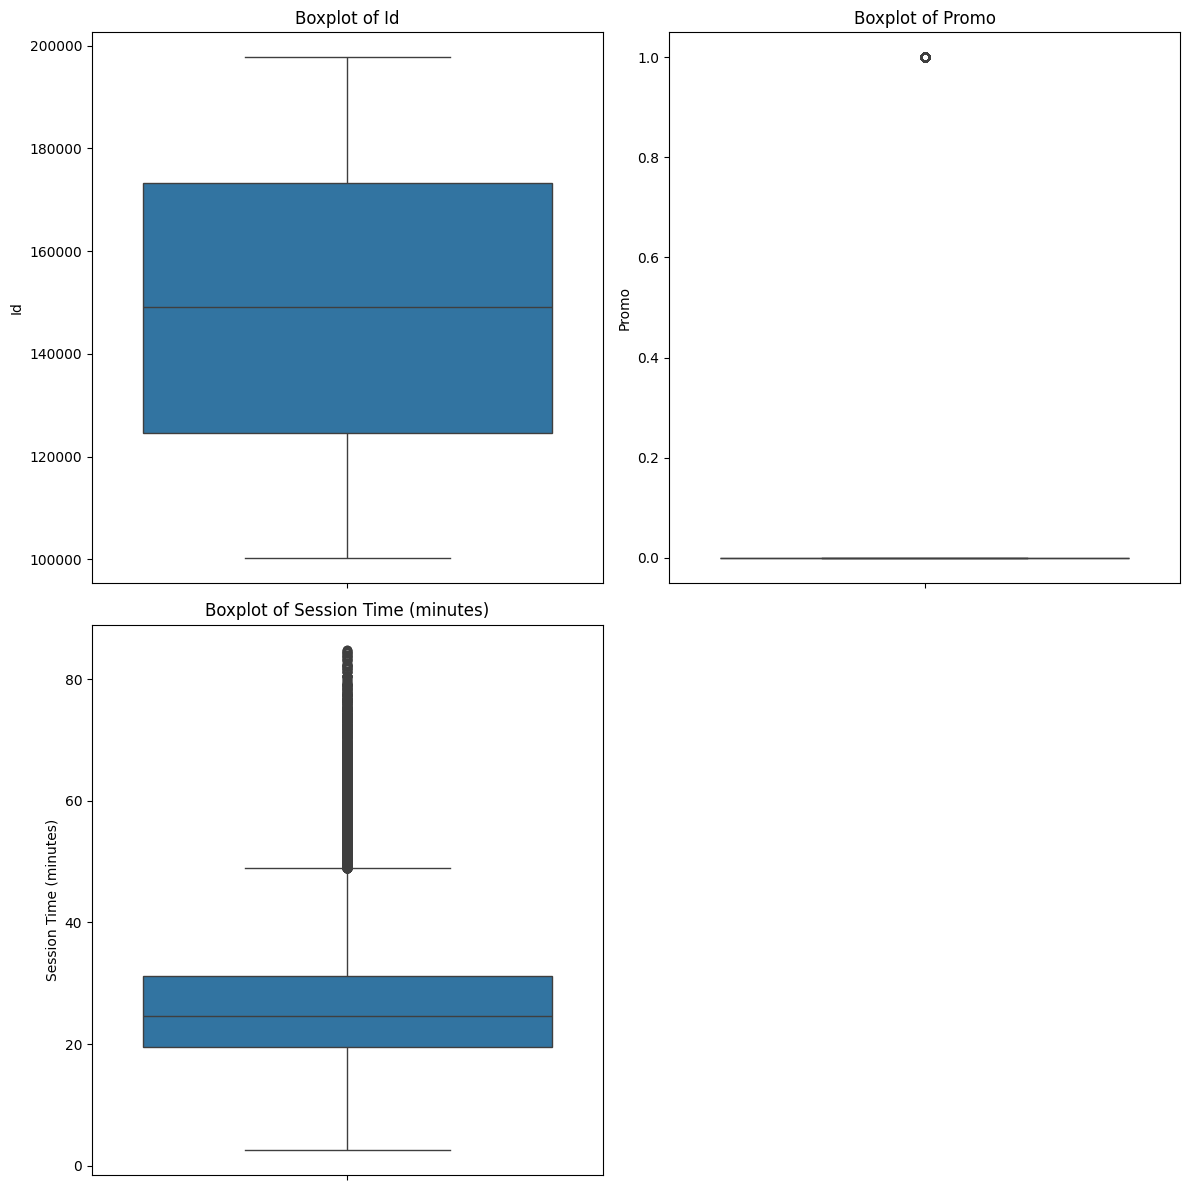

In [79]:
def plot_numeric_boxplots(df, figsize=(12, 6), plot_per_row=2):
    """
    Строит boxplot'ы для всех числовых столбцов в DataFrame.
    
    Параметры:
    -----------
    df : pandas.DataFrame
        Входной DataFrame с данными
    figsize : tuple, optional
        Размер графика (ширина, высота) в дюймах, по умолчанию (12, 6)
    plot_per_row : int, optional
        Количество boxplot'ов в одной строке, по умолчанию 2
    
    Возвращает:
    --------
    None
        Отображает графики, но не возвращает значений
    """
    # Выберите только числовые столбцы (как целочисленные, так и с плавающей точкой).
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    n_columns = len(numeric_columns)
    
    if n_columns == 0:
        print("No numeric columns found in the DataFrame")
        return
    
    # Вычислить необходимое количество строк
    n_rows = (n_columns + plot_per_row - 1) // plot_per_row
    
    # Создание подзаголовков
    fig, axes = plt.subplots(n_rows, plot_per_row, figsize=(figsize[0], figsize[1] * n_rows))
    
    # Сгладить массив осей для упрощения итерации
    if n_rows == 1 and plot_per_row == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Создание коробочных графиков
    for idx, column in enumerate(numeric_columns):
        sns.boxplot(data=df, y=column, ax=axes[idx])
        axes[idx].set_title(f'Boxplot of {column}')
        axes[idx].set_ylabel(column)
    
    # Удалить пустые подзаголовки, если таковые имеются
    for idx in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()


# df = pd.DataFrame(your_data)
plot_numeric_boxplots(df)
# plot_numeric_boxplots(df2) - No numeric columns found in the DataFrame

## <span style="color:#006400">Просмотр имеюшихся данных  </span>

#### Данные в rides.csv

In [80]:
df.head(10)

,Id,Start Date,End Date,Start Location,Start District,End Location,End District,Distance,Promo,Session Time,Session Time (minutes)
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069,0,00:23:42,23.700000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515,0,00:28:25,28.416667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520,0,00:38:19,38.316667
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881,0,00:31:49,31.816667
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029,0,00:30:40,30.666667
5,100345,2023-04-22 09:10:09,2023-04-22 09:49:56,Лесная,Юго-Восточный,Западная,Ленинский,4879,0,00:39:47,39.783333
6,100346,2023-04-22 09:15:12,2023-04-22 09:26:01,Пролетарская,Центральный,Свободы,Ленинский,1846,0,00:10:49,10.816667
7,100347,2023-04-22 09:19:13,2023-04-22 09:40:03,Комарова,Ленинский,ул. западная,Ленинский,3133,0,00:20:50,20.833333
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,Западная,ленинский,Озерная,Юго-Восточный,3,0,00:17:22,17.366667
9,100349,2023-04-22 09:28:00,2023-04-22 10:02:08,Свободы,ленинский,ул. чкалова,юго-восточный,5263,0,00:34:08,34.133333


In [81]:
#Анализирует DataFrame: проверяет пропуски, дубликаты, выводит статистику и примеры данных для числовых и категориальных столбцов
def check_data(data_df):
    print ('\033[5m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())

    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head(2)) #tail()

    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T)

    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())


check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
Index: 101022 entries, 0 to 102254
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      101022 non-null  int64         
 1   Start Date              101022 non-null  datetime64[ns]
 2   End Date                100443 non-null  datetime64[ns]
 3   Start Location          101022 non-null  object        
 4   Start District          101022 non-null  object        
 5   End Location            101022 non-null  object        
 6   End District            101022 non-null  object        
 7   Distance                101022 non-null  int32         
 8   Promo                   101022 non-null  int64         
 9   Session Time            101022 non-null  object        
 10  Session Time (minutes)  100443 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int32(1), int64(2), object(5)
memory us

,Id,Start Date,End Date,Start Location,Start District,End Location,End District,Distance,Promo,Session Time,Session Time (minutes)
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069,0,00:23:42,23.700000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515,0,00:28:25,28.416667



Описание количественных данных:


,count,mean,min,25%,50%,75%,max,std
Id,101022.0,149019.395538,100340.0,124690.25,149027.5,173342.75,197711.0,28103.094972
Start Date,101022,2023-06-13 20:57:30.186236672,2023-04-22 09:01:03,2023-05-20 21:47:00.249999872,2023-06-14 15:19:38,2023-07-08 19:36:17.249999872,2023-07-31 23:57:01,NaN
End Date,100443,2023-06-13 21:06:19.343727616,2023-04-22 09:24:45,2023-05-20 22:11:22.500000,2023-06-14 15:10:55,2023-07-08 19:53:26,2023-08-01 00:42:12,NaN
Distance,101022.0,27291.098424,1.0,3044.0,3702.0,4429.0,7569789.0,309718.565282
Promo,101022.0,0.019788,0.0,0.0,0.0,0.0,1.0,0.139271
Session Time (minutes),100443.0,26.369183,2.566667,19.466667,24.616667,31.233333,84.833333,9.946486



Описание категориальных данных:


,count,unique,top,freq
Start Location,101022,463,Ломоносова,1659
Start District,101022,13,Центральный,17885
End Location,101022,492,Спортивная,1497
End District,101022,14,Центральный,18662
Session Time,101022,3800,NaT,579



Вывод уникальных значений по каждому категориаьному признаку:
_Start Location


Start Location
Ломоносова           1659
Луговая              1633
Майская              1626
Восточная            1571
Спортивная           1560
                     ... 
Ул. Центральная         1
Ул. Северная            1
Ул. Энтузиастов         1
Ул. Матросова           1
Ул. Комсомольская       1
Name: count, Length: 463, dtype: int64

_Start District


Start District
Центральный        17885
Юго-Восточный      13357
Северо-Западный    11175
Ленинский          11169
Октябрьский         9612
центральный         8164
Заречный            6723
юго-восточный       5806
ленинский           4960
северо-западный     4918
октябрьский         4282
заречный            2970
северо западный        1
Name: count, dtype: int64

_End Location


End Location
Спортивная      1497
Восточная       1428
Ломоносова      1424
Буденного       1388
Луговая         1387
                ... 
ул почтовая        1
Ул. Заречная       1
Ул. Мичурина       1
Ул. Шевченко       1
ул матросова       1
Name: count, Length: 492, dtype: int64

_End District


End District
Центральный        18662
Юго-Восточный      14421
Ленинский          11955
Северо-Западный    11926
Октябрьский        10390
Заречный            6905
центральный         6724
юго-восточный       5152
северо-западный     4353
ленинский           4252
октябрьский         3749
заречный            2478
Северо Западный       33
северо западный       22
Name: count, dtype: int64

_Session Time


Session Time
NaT         579
00:22:37    110
00:20:23    109
00:21:37    105
00:20:22    104
           ... 
01:01:13      1
01:11:12      1
00:08:06      1
01:00:59      1
00:02:34      1
Name: count, Length: 3800, dtype: int64

#### Данные в weather.csv

In [82]:
df2.head(10)

,Datetime,Temperature,Precipitation Total,Wind Gust,Wind Speed,Cloud Cover Total,Sunshine Duration
0,NaN,°C,mm,km/h,km/h,%,min
1,2023-04-01T00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2023-04-01T01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,2023-04-01T02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,2023-04-01T03:00:00,8.690246,0.3,55.44,21.94524,77,0
5,2023-04-01T04:00:00,8.630245,0.3,48.96,22.42427,78,0
6,2023-04-01T05:00:00,8.430245,0.5,48.6,22.91026,77,0
7,2023-04-01T06:00:00,8.690246,0.3,50.039997,23.1774,98,0.5287884
8,2023-04-01T07:00:00,8.860246,0.4,52.56,23.166216,89,6.060605
9,2023-04-01T08:00:00,8.640245,0.5,63,20.371038,92,4.242425


In [83]:
#Анализирует DataFrame: проверяет пропуски, дубликаты, выводит статистику и примеры данных для числовых и категориальных столбцов
def check_data(data_df):
    print ('\033[5m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())

    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head(2)) #tail()

    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T)

    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())


check_data(df2)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Datetime             3672 non-null   object
 1   Temperature          3618 non-null   object
 2   Precipitation Total  3643 non-null   object
 3   Wind Gust            3673 non-null   object
 4   Wind Speed           3657 non-null   object
 5   Cloud Cover Total    3653 non-null   object
 6   Sunshine Duration    3661 non-null   object
dtypes: object(7)
memory usage: 201.0+ KB
None

Проверка пропусков
Количество пропусков: 134
Доля пропусков: 0.6%
Доля строк содержащих пропуски: 3.6%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,Datetime,Temperature,Precipitation Total,Wind Gust,Wind Speed,Cloud Cover Total,Sunshine Duration
0,NaN,°C,mm,km/h,km/h,%,min
1,2023-04-01T00:00:00,8.740245,0.1,48.6,21.638964,90,0



Описание количественных данных:


,count,unique,top,freq
Datetime,3672,3672,2023-08-31T23:00:00,1
Temperature,3618,1964,27.540245,9
Precipitation Total,3643,36,0,2966
Wind Gust,3673,163,11.5199995,86
Wind Speed,3657,709,4.3349743,36
Cloud Cover Total,3653,197,0,251
Sunshine Duration,3661,495,0,1309



Описание категориальных данных:


,count,unique,top,freq
Datetime,3672,3672,2023-08-31T23:00:00,1
Temperature,3618,1964,27.540245,9
Precipitation Total,3643,36,0,2966
Wind Gust,3673,163,11.5199995,86
Wind Speed,3657,709,4.3349743,36
Cloud Cover Total,3653,197,0,251
Sunshine Duration,3661,495,0,1309



Вывод уникальных значений по каждому категориаьному признаку:
_Datetime


Datetime
2023-08-31T23:00:00    1
2023-04-01T00:00:00    1
2023-04-01T01:00:00    1
2023-04-01T02:00:00    1
2023-04-01T03:00:00    1
                      ..
2023-04-01T12:00:00    1
2023-04-01T11:00:00    1
2023-04-01T10:00:00    1
2023-04-01T09:00:00    1
2023-04-01T08:00:00    1
Name: count, Length: 3672, dtype: int64

_Temperature


Temperature
27.540245     9
25.610245     8
15.040245     8
11.250245     7
20.140245     6
             ..
15.410245     1
14.290245     1
14.850245     1
13.3102455    1
12.710245     1
Name: count, Length: 1964, dtype: int64

_Precipitation Total


Precipitation Total
0      2966
0.1     146
0.2     144
0.3      89
0.4      54
0.6      38
0.5      33
0.8      23
0.7      21
1.2      15
1.3      15
0.9      13
1.1      12
1.4      10
1         8
1.6       7
1.5       7
1.8       6
1.7       6
2.2       6
2.1       4
2.4       2
2.3       2
2         2
1.9       2
2.6       2
mm        1
2.9       1
3         1
5         1
5.8       1
3.3       1
3.9       1
3.4       1
2.8       1
2.7       1
Name: count, dtype: int64

_Wind Gust


Wind Gust
11.5199995    86
13.32         81
11.879999     73
13.679999     73
15.4800005    72
              ..
67.67999       1
65.520004      1
66.96          1
65.159996      1
58.679996      1
Name: count, Length: 163, dtype: int64

_Wind Speed


Wind Speed
4.3349743    36
5.3517847    34
6.28713      33
3.319036     33
4.0249224    32
             ..
23.132626     1
25.600533     1
22.42427      1
21.94524      1
22.26477      1
Name: count, Length: 709, dtype: int64

_Cloud Cover Total


Cloud Cover Total
0            251
100           97
1             56
98            48
20            45
            ... 
19.2           1
14.1           1
18.300001      1
14.400001      1
13.500001      1
Name: count, Length: 197, dtype: int64

_Sunshine Duration


Sunshine Duration
0            1309
60            143
41.81818       37
59.393936      31
4.8484864      28
             ... 
2.2343435       1
26.962963       1
19.630304       1
53.81818        1
32.435688       1
Name: count, Length: 495, dtype: int64

## <span style="color:#006400">Начало предобработки  </span>

### Данные в rides.csv

#### преобразуем все столбцы в стандард pep-8

In [84]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes)
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069,0,00:23:42,23.700000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515,0,00:28:25,28.416667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520,0,00:38:19,38.316667
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881,0,00:31:49,31.816667
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029,0,00:30:40,30.666667


#### наведем порядок в типах данных

##### Было: 

In [85]:
df.dtypes

id                                 int64
start_date                datetime64[ns]
end_date                  datetime64[ns]
start_location                    object
start_district                    object
end_location                      object
end_district                      object
distance                           int32
promo                              int64
session_time                      object
session_time_(minutes)           float64
dtype: object

##### Стало:

In [86]:
# Преобразование столбцов с локациями в строковый тип (text/string)
location_columns = ['start_location', 'start_district', 'end_location', 'end_district']
df[location_columns] = df[location_columns].astype('string')

# Преобразуем в строку формата HH:MM:SS
df['session_time'] = pd.to_timedelta(df['session_time']).astype(str).str[-8:]
print(df.dtypes)

id                                 int64
start_date                datetime64[ns]
end_date                  datetime64[ns]
start_location            string[python]
start_district            string[python]
end_location              string[python]
end_district              string[python]
distance                           int32
promo                              int64
session_time                      object
session_time_(minutes)           float64
dtype: object


In [87]:
# тип данных в session_time можно сделать timedelta, но тогда будут указывать данные в формате дней:часов:минут:секунд а для красоты пока что оставлю 
# тип object. (позже улдалить эту колонку(т.к есть Session Time (minutes)))

#### Очистим и стандартизируем форматы адресов ()

In [88]:
df['start_location'] = list(map(lambda x: x.lower().replace('ул. ', '').replace('ул.', '').replace('ул ', ''), df['start_location']))
df['end_location'] = list(map(lambda x: x.lower().replace('ул. ', '').replace('ул.', '').replace('ул ', ''), df['end_location']))
df['start_district'] = list(map(lambda x: x.lower(), df['start_district']))
df['end_district'] = list(map(lambda x: x.lower(), df['end_district']))
df

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes)
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069,0,00:23:42,23.700000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515,0,00:28:25,28.416667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520,0,00:38:19,38.316667
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881,0,00:31:49,31.816667
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029,0,00:30:40,30.666667
...,...,...,...,...,...,...,...,...,...,...,...
102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,озерная,юго-восточный,первомайская,северо-западный,3302,0,00:21:49,21.816667
102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,мичурина,ленинский,садовая,заречный,4992,0,00:39:34,39.566667
102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,лермонтова,ленинский,куйбышева,центральный,2781,0,00:21:17,21.283333
102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,рябиновая,северо-западный,энергетиков,юго-восточный,6466,0,00:46:23,46.383333


### Данные в weather.csv

#### преобразуем все столбцы в стандард pep-8

In [89]:
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2.head()

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,NaN,°C,mm,km/h,km/h,%,min
1,2023-04-01T00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2023-04-01T01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,2023-04-01T02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,2023-04-01T03:00:00,8.690246,0.3,55.44,21.94524,77,0


#### наведем порядок в типах данных

##### Было: 

In [90]:
df2.dtypes

datetime               object
temperature            object
precipitation_total    object
wind_gust              object
wind_speed             object
cloud_cover_total      object
sunshine_duration      object
dtype: object

##### Стало: 

In [91]:
#первую строку надо удалить, чтобы типы преобразовать
units = {
    'temperature': '°C',
    'precipitation_total': 'mm',
    'wind_gust': 'km/h',
    'wind_speed': 'km/h',
    'cloud_cover_total': '%',
    'sunshine_duration': 'min'
}

df2 = df2.iloc[1:].reset_index(drop=True)

df2 = df2.astype({
    'datetime': 'datetime64[ns]',
    'temperature': 'float64',
    'precipitation_total': 'float64',
    'wind_gust': 'float64',
    'wind_speed': 'float64',
    'cloud_cover_total': 'float64',
    'sunshine_duration': 'float64'
})
print(df2.dtypes)
df2

datetime               datetime64[ns]
temperature                   float64
precipitation_total           float64
wind_gust                     float64
wind_speed                    float64
cloud_cover_total             float64
sunshine_duration             float64
dtype: object


,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,2023-04-01 00:00:00,8.740245,0.1,48.600000,21.638964,90.0,0.0
1,2023-04-01 01:00:00,9.040245,0.2,55.440000,22.493519,74.0,0.0
2,2023-04-01 02:00:00,8.880245,0.3,55.800000,22.264770,72.0,0.0
3,2023-04-01 03:00:00,8.690246,0.3,55.440000,21.945240,77.0,0.0
4,2023-04-01 04:00:00,8.630245,0.3,48.960000,22.424270,78.0,0.0
...,...,...,...,...,...,...,...
3667,2023-08-31 19:00:00,16.940245,0.0,10.799999,1.080000,89.0,1.5
3668,2023-08-31 20:00:00,16.630245,0.0,11.159999,1.138420,83.0,0.0
3669,2023-08-31 21:00:00,17.080246,0.1,17.640000,3.396233,82.0,0.0
3670,2023-08-31 22:00:00,17.180244,0.0,21.599998,7.235910,80.0,0.0


## <span style="color:#006400">Посмотрим на дубликаты и пропуски </span>

### Данные в rides.csv

#### Полные дубликаты и по столбцам

In [92]:
duplicates = df[df.duplicated()]  # keep=False
print(f"Найдено {len(duplicates)} полных дубликатов")

Найдено 4831 полных дубликатов


In [93]:
df.isna().sum()

id                          0
start_date                  0
end_date                  579
start_location              0
start_district              0
end_location                0
end_district                0
distance                    0
promo                       0
session_time                0
session_time_(minutes)    579
dtype: int64

In [94]:
## при удалении полных дубликатов получим  101022 - 4831 = 96191 строк данных (сейчас показывает 579 пропусков, но после удаления полных дубликатов 
## получим 555 пропусков (проверял в другом notebook)) из этого  следует 2 вывода 1) мы можем просто удалить данные пропуски т.к. они составляют 
## всего лишь 0,58% от всех данных ((555 * 100)/96191) либо 2) проведем небольшое исследование данных пропусков:    

#### исследование пропусков в end_date 

In [95]:
#Выводит топ-5 стартовых точек поездок с пропущенными датами окончания (end_date)
missing_data = df[df['end_date'].isna()]
print("Типичные стартовые точки для поездок без end_date:")
print(missing_data['start_location'].value_counts().head(5))

Типичные стартовые точки для поездок без end_date:
start_location
спортивная    21
майская       16
восточная     15
ломоносова    13
луговая       13
Name: count, dtype: int64


In [96]:
# Заполнить пропуски средним временем поездки для этих локаций
# for location in ['Спортивная', 'Ломоносова', 'Майская', 'Восточная', 'Чехова']:
#     avg_time = df[df['start_location'] == location]['session_time_(minutes)'].mean()
#     df.loc[(df['start_location'] == location) & (df['end_date'].isna()), 'session_time_(minutes)'] = avg_time
#     df.loc[(df['start_location'] == location) & (df['end_date'].isna()), 'end_date'] = \
#         df['start_date'] + pd.to_timedelta(avg_time, unit='minutes')

In [97]:
# таким образом мы можем заполнить пропуски средним временем поездки для часто встречаюшихся локаций

#### Посмотрим на повторяющиеся значения в других столбцах

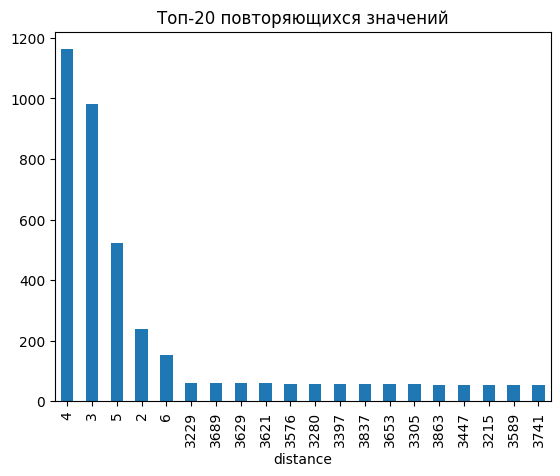

In [98]:
df['distance'].value_counts().head(20).plot(kind='bar')
plt.title("Топ-20 повторяющихся значений")
plt.show()

In [99]:
##слишком много значений <100 в колонке distance (нужно посмотреть внимательнее возможно это будут выбросы) (потом мы их очистили см. далее)

<span style="color:#006400">Посмотрим на выбросы(есть ли они вообще) ## </span>

#### Заметим из предыдущего шага, что в distance есть данные <= 100 (250/500/1000)

In [100]:
df[df["distance"] <= 1000]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes)
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,западная,ленинский,озерная,юго-восточный,3,0,00:17:22,17.366667
21,100360,2023-04-22 10:01:51,2023-04-22 10:31:17,лермонтова,ленинский,дружбы,центральный,5,0,00:29:26,29.433333
67,100405,2023-04-22 11:08:22,2023-04-22 12:00:35,ленина,ленинский,овражная,центральный,5,0,00:52:13,52.216667
70,100408,2023-04-22 11:18:25,2023-04-22 11:36:19,строительная,северо-западный,строительная,северо-западный,4,0,00:17:54,17.900000
108,100443,2023-04-22 12:16:46,2023-04-22 12:50:14,заводская,северо-западный,свердлова,центральный,4,0,00:33:28,33.466667
...,...,...,...,...,...,...,...,...,...,...,...
102007,197473,2023-07-31 19:44:01,2023-07-31 20:29:57,гоголя,центральный,энтузиастов,центральный,3,0,00:45:56,45.933333
102072,197538,2023-07-31 20:23:15,2023-07-31 20:53:32,полевая,ленинский,чапаева,северо-западный,3,0,00:30:17,30.283333
102117,197581,2023-07-31 20:57:53,2023-07-31 21:33:29,октябрьская,заречный,солнечная,центральный,6,0,00:35:36,35.600000
102149,197611,2023-07-31 21:22:02,2023-07-31 21:40:39,трудовая,центральный,гоголя,центральный,4,0,00:18:37,18.616667


In [101]:
# Видно, что в distance	- 3122 значения <= 1000, их стоит считать выбросами  т.к. 
# 1) Они составляют аномально малую дистанцию по сравнению с основным распределением данных 
# 2) Могут быть ошибками измерений или техническими артефактами (например, тестовые поездки или сбои GPS)

#### проверим другие столбцы 

In [102]:
df[df["session_time_(minutes)"] >= 60]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes)
357,100679,2023-04-22 16:21:14,2023-04-22 17:30:01,рябиновая,северо-западный,нагорная,центральный,5690,0,01:08:47,68.783333
435,100751,2023-04-22 17:09:36,2023-04-22 18:23:37,речная,юго-восточный,спортивная,октябрьский,4466,0,01:14:01,74.016667
544,100855,2023-04-22 18:28:51,2023-04-22 19:37:36,майская,октябрьский,солнечная,центральный,5117,0,01:08:45,68.750000
564,100874,2023-04-22 18:37:57,2023-04-22 19:43:22,цветочная,северо-западный,комсомольская,заречный,4134,0,01:05:25,65.416667
661,100963,2023-04-22 19:28:01,2023-04-22 20:32:09,октябрьская,заречный,комарова,ленинский,6992,0,01:04:08,64.133333
...,...,...,...,...,...,...,...,...,...,...,...
101366,196863,2023-07-31 08:32:44,2023-07-31 09:45:04,ленина,ленинский,пионерская,заречный,7154,1,01:12:20,72.333333
101779,197255,2023-07-31 16:44:38,2023-07-31 17:45:54,озерная,юго-восточный,новая,северо-западный,5537,0,01:01:16,61.266667
101839,197313,2023-07-31 17:45:13,2023-07-31 18:53:48,красная,северо-западный,энергетиков,юго-восточный,4935,0,01:08:35,68.583333
101929,197397,2023-07-31 18:59:00,2023-07-31 20:06:21,рябиновая,северо-западный,дзержинского,центральный,5144,0,01:07:21,67.350000


### Данные в weather.csv

#### Полные дубликаты и по столбцам

In [103]:
duplicates = df2[df2.duplicated()]
print(f"Найдено {len(duplicates)} полных дубликатов")

Найдено 0 полных дубликатов


In [104]:
df2.isna().sum()

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

#### заполнение дубликатов по столбцам

заполнение пропусков в weather 

Пропуски до обработки:
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64


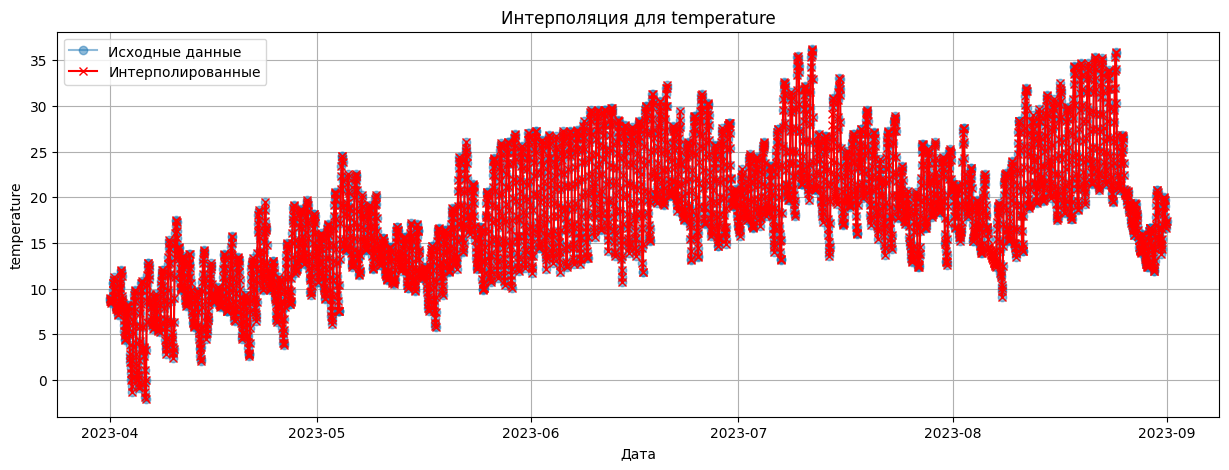

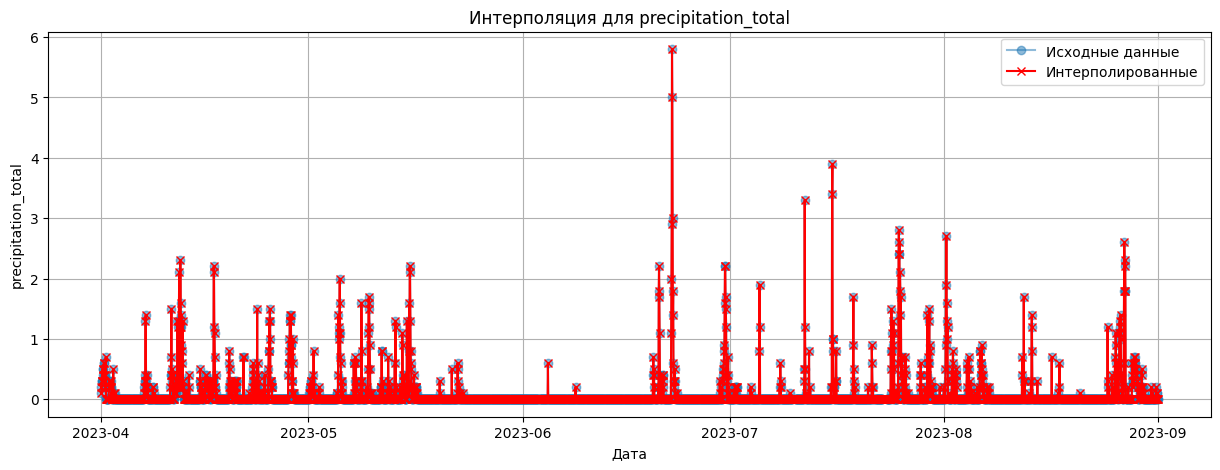

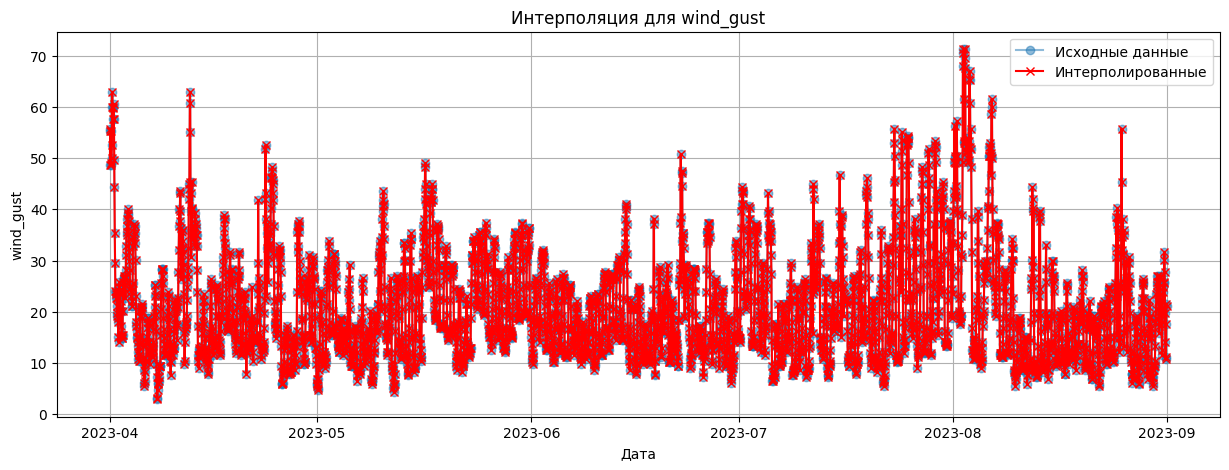

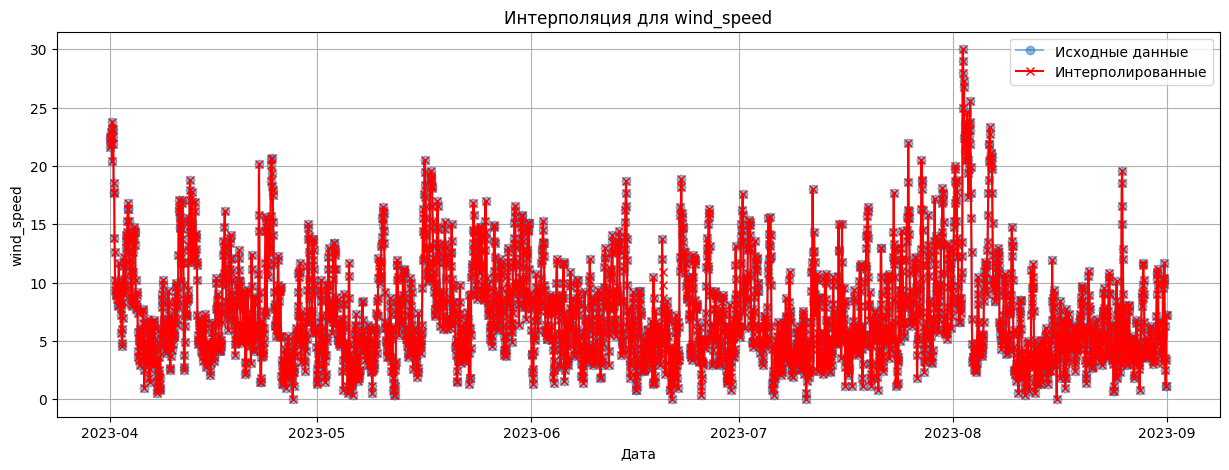

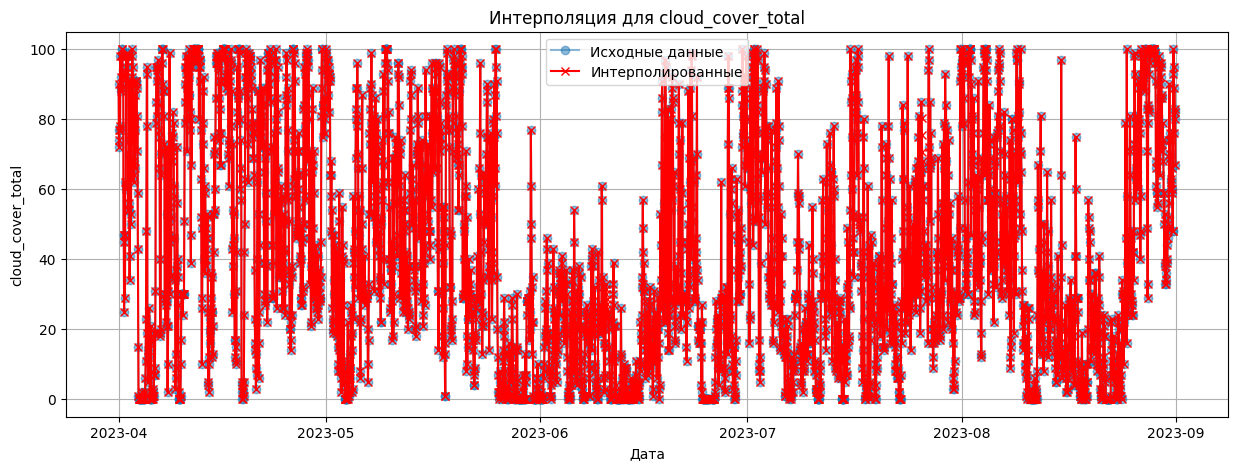

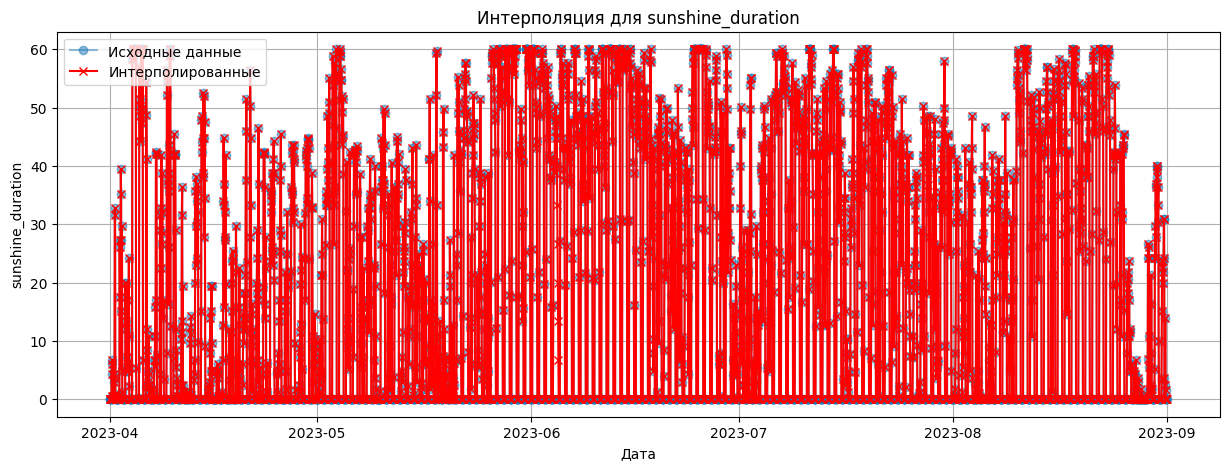


Пропуски после обработки:
temperature            0
precipitation_total    0
wind_gust              0
wind_speed             0
cloud_cover_total      0
sunshine_duration      0
dtype: int64


In [105]:
df2 = pd.read_csv("testwather2_data.csv", sep=',', encoding='utf-8')
df2.columns = df2.columns.str.lower().str.replace(' ', '_')

# Преобразование типов
df2['datetime'] = pd.to_datetime(df2['datetime'])
numeric_cols = ['temperature', 'precipitation_total', 'wind_gust', 'wind_speed', 
               'cloud_cover_total', 'sunshine_duration']
df2[numeric_cols] = df2[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Устанавливаем datetime в качестве индекса
df2.set_index('datetime', inplace=True)

# Анализ пропусков
print("Пропуски до обработки:")
print(df2.isna().sum())

# Функция для интерполяции с визуализацией
def interpolate_and_plot(column, method='linear', limit=None, limit_direction='both'):
    original = df2[column].copy()
    interpolated = original.interpolate(method=method, limit=limit, limit_direction=limit_direction)
    
    # Для оставшихся пропусков используем заполнение вперед/назад
    if interpolated.isna().any():
        interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')
    
    plt.figure(figsize=(15, 5))
    plt.plot(original.index, original, 'o-', label='Исходные данные', alpha=0.5)
    plt.plot(interpolated.index, interpolated, 'x-', label='Интерполированные', color='red')
    plt.title(f'Интерполяция для {column}')
    plt.xlabel('Дата')
    plt.ylabel(column)
    plt.legend()
    plt.grid()
    plt.show()
    
    return interpolated

# Применяем интерполяцию к каждому столбцу
for column in numeric_cols:
    df2[column] = interpolate_and_plot(column, method='time')  # временную интерполяцию
    
print("\nПропуски после обработки:")
print(df2.isna().sum())

assert df2.isna().sum().sum() == 0, "Остались незаполненные значения!"

## <span style="color:#006400">Удалим все не нужное / Заполним все нужное</span>

#### 1) удалим полные дубликаты  (4831 удалаяем)

In [106]:
df = df.drop_duplicates()
df

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes)
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069,0,00:23:42,23.700000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515,0,00:28:25,28.416667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520,0,00:38:19,38.316667
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881,0,00:31:49,31.816667
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029,0,00:30:40,30.666667
...,...,...,...,...,...,...,...,...,...,...,...
102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,озерная,юго-восточный,первомайская,северо-западный,3302,0,00:21:49,21.816667
102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,мичурина,ленинский,садовая,заречный,4992,0,00:39:34,39.566667
102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,лермонтова,ленинский,куйбышева,центральный,2781,0,00:21:17,21.283333
102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,рябиновая,северо-западный,энергетиков,юго-восточный,6466,0,00:46:23,46.383333


#### 2) заполним пропуски в end_date и session_time_(minutes) (сразу округлим сделав данные красивыми)

In [107]:
df["distance"] = pd.to_numeric(df["distance"], errors="coerce")

# Удаление строк с некорректными расстояниями
df = df.dropna(subset=["distance"])

# Расчет продолжительности поездки в часах
df["duration"] = (df["end_date"] - df["start_date"]).dt.total_seconds() / 3600

# Фильтрация валидных записей
valid_mask = (df["duration"] > 0) & (df["distance"] > 0)
valid_entries = df[valid_mask].copy()  # Явное создание копии

# Расчет средней скорости
valid_entries["speed"] = valid_entries["distance"] / valid_entries["duration"]
average_speed = valid_entries["speed"].median()

# Восстановление end_date для дубликатов
duplicate_mask = df.duplicated(subset=["end_date"], keep=False)
df.loc[duplicate_mask, "end_date"] = df.loc[duplicate_mask, "start_date"] + pd.to_timedelta(
    df.loc[duplicate_mask, "distance"] / average_speed, 
    unit="h"
)

df = df.drop(columns=["duration"])

C:\Users\mailm\AppData\Local\Temp\ipykernel_13136\723006694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["distance"] = pd.to_numeric(df["distance"], errors="coerce")


In [108]:
df.isna().sum()

id                          0
start_date                  0
end_date                    0
start_location              0
start_district              0
end_location                0
end_district                0
distance                    0
promo                       0
session_time                0
session_time_(minutes)    555
dtype: int64

In [109]:
def calculate_session_time(df):
    df = df.copy()
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])
    
    # Рассчитываем продолжительность поездки
    df['session_time'] = df['end_date'] - df['start_date']
    
    # Преобразуем в строку формата HH:MM:SS (без миллисекунд)
    df['session_time'] = df['session_time'].apply(
        lambda x: str(x).split()[-1].split('.')[0] if 'days' in str(x) else str(x).split('.')[0]
    )
    
    # Рассчитываем продолжительность в минутах и округляем до 6 знаков после запятой
    df['session_time_(minutes)'] = round(pd.to_timedelta(df['session_time']).dt.total_seconds() / 60, 6)
    
    # Округляем end_date до секунд (удаляем миллисекунды)
    df['end_date'] = df['end_date'].dt.floor('s')
    
    return df

df = calculate_session_time(df)

In [110]:
# Округляем столбец 'session_time_(minutes)' до 6 знаков после запятой
df['session_time_(minutes)'] = df['session_time_(minutes)'].round(1)

# Или до 2 знаков, если нужно:
# df['session_time_(minutes)'] = df['session_time_(minutes)'].round(2)

In [111]:
df.isna().sum()

id                        0
start_date                0
end_date                  0
start_location            0
start_district            0
end_location              0
end_district              0
distance                  0
promo                     0
session_time              0
session_time_(minutes)    0
dtype: int64

#### 3) удалим  значения которые являються выбросами по колонке distance

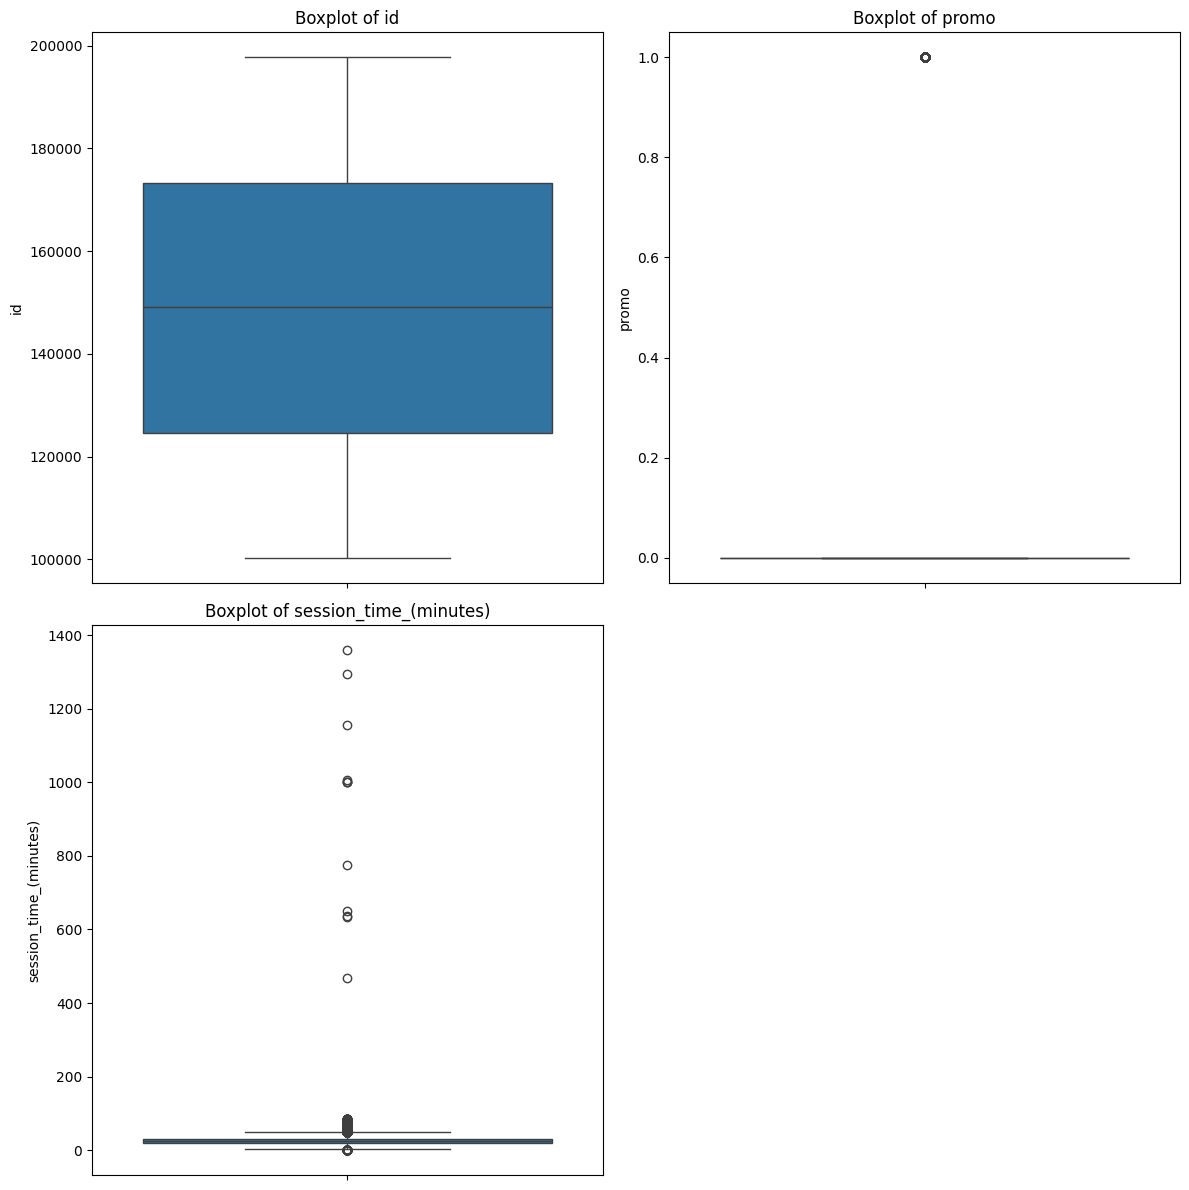

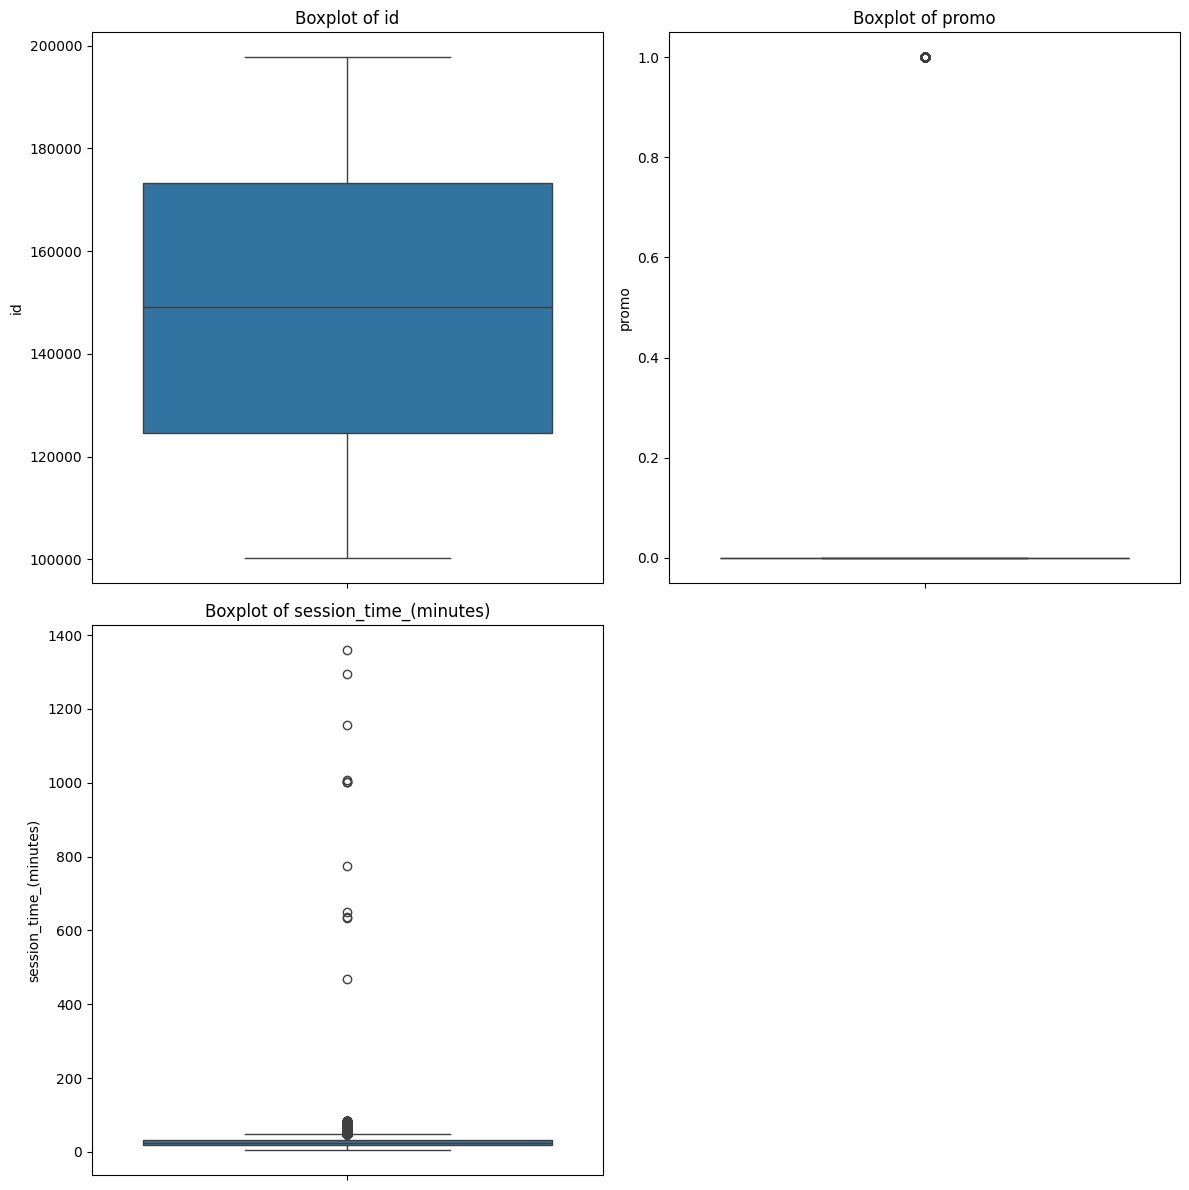

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes)
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069,0,00:23:42,23.7
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515,0,00:28:25,28.4
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520,0,00:38:19,38.3
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881,0,00:31:49,31.8
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029,0,00:30:40,30.7
...,...,...,...,...,...,...,...,...,...,...,...
102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,озерная,юго-восточный,первомайская,северо-западный,3302,0,00:21:49,21.8
102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,мичурина,ленинский,садовая,заречный,4992,0,00:39:34,39.6
102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,лермонтова,ленинский,куйбышева,центральный,2781,0,00:21:17,21.3
102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,рябиновая,северо-западный,энергетиков,юго-восточный,6466,0,00:46:23,46.4


In [112]:
df = clean_data_with_threshold(df, "distance", 1000, "below")
df

#### 4)посмотрим и почистим данные в session_time_(minutes)

In [113]:
df[df["session_time_(minutes)"]>=200]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes)
7334,107304,2023-04-30 15:12:50,2023-05-19 23:01:44,озерная,юго-восточный,чапаева,северо-западный,4227698,0,07:48:54,468.9
10158,110004,2023-05-03 18:18:24,2023-05-27 07:13:18,комсомольская,заречный,заводская,северо-западный,5149229,0,12:54:54,774.9
10326,110168,2023-05-03 20:21:01,2023-05-16 19:01:11,свободы,ленинский,южная,центральный,2831768,0,22:40:10,1360.2
12064,111814,2023-05-05 21:39:02,2023-05-31 14:26:04,заречная,юго-восточный,заводская,северо-западный,5622015,0,16:47:02,1007.0
31853,130683,2023-05-27 15:23:31,2023-06-08 12:57:37,совхозная,центральный,труда,центральный,2602970,0,21:34:06,1294.1
33911,132635,2023-05-28 21:57:48,2023-06-21 14:39:51,спортивная,октябрьский,мичурина,ленинский,5183736,0,16:42:03,1002.0
54273,152031,2023-06-17 16:13:03,2023-06-24 02:49:14,маяковского,центральный,матросова,центральный,1409216,0,10:36:11,636.2
59166,156662,2023-06-22 10:12:20,2023-07-14 02:53:29,береговая,центральный,озерная,юго-восточный,4746079,0,16:41:09,1001.2
63049,160352,2023-06-25 18:40:07,2023-07-13 11:21:53,совхозная,центральный,октябрьская,заречный,3871126,0,16:41:46,1001.8
78077,174691,2023-07-09 19:44:58,2023-07-31 06:35:30,железнодорожная,центральный,чкалова,юго-восточный,4692813,0,10:50:32,650.5


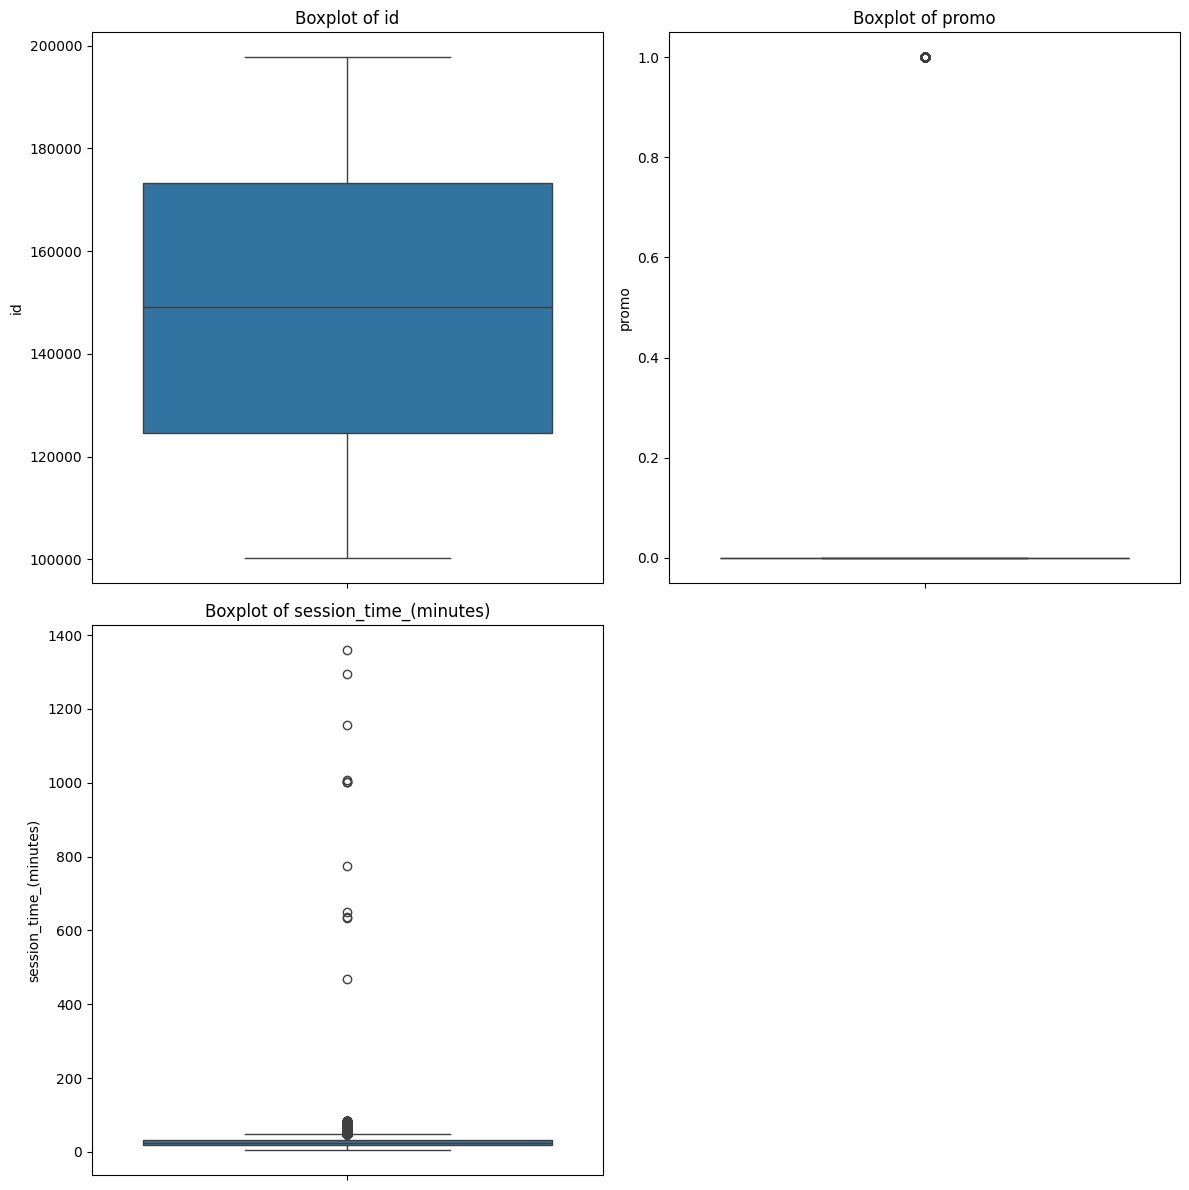

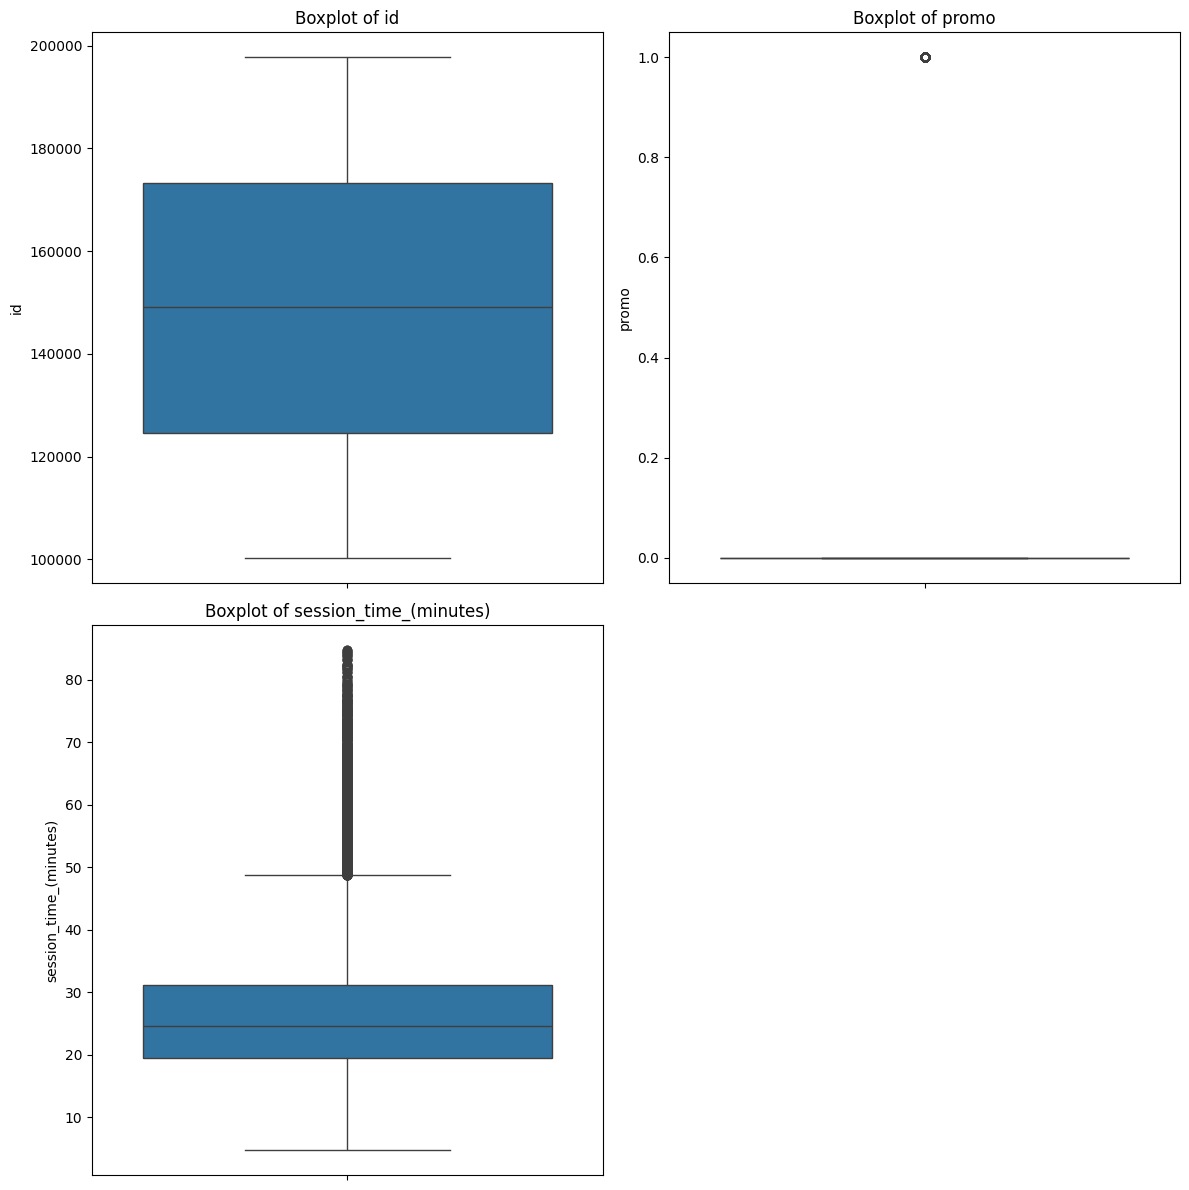

In [114]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 200, "above")

In [115]:
df[df["session_time_(minutes)"] <= 0]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes)


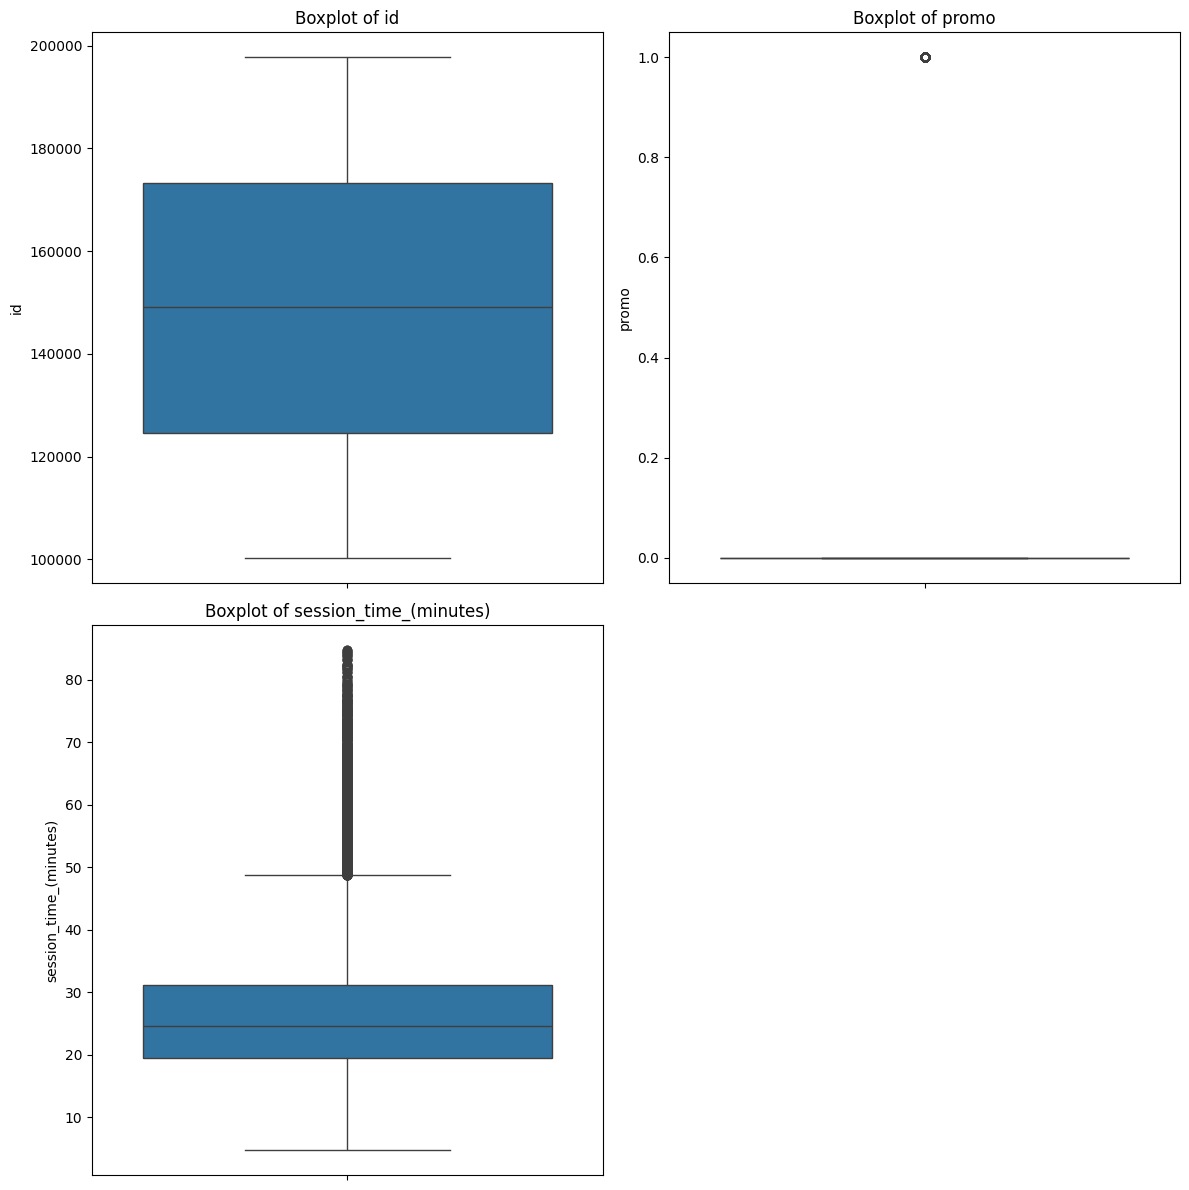

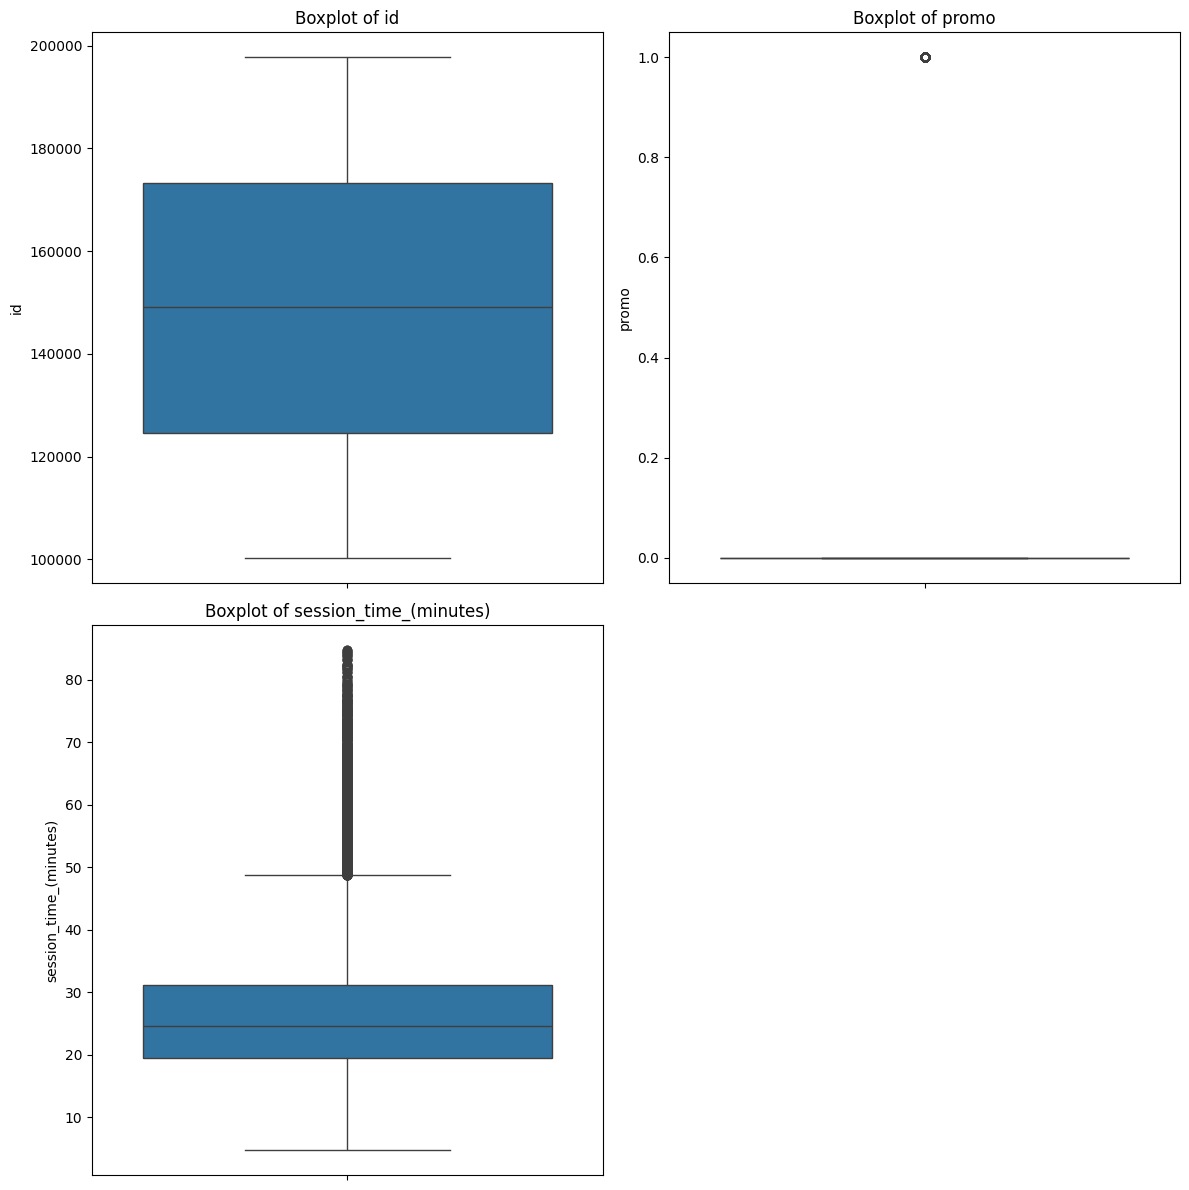

In [116]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 0, "below")

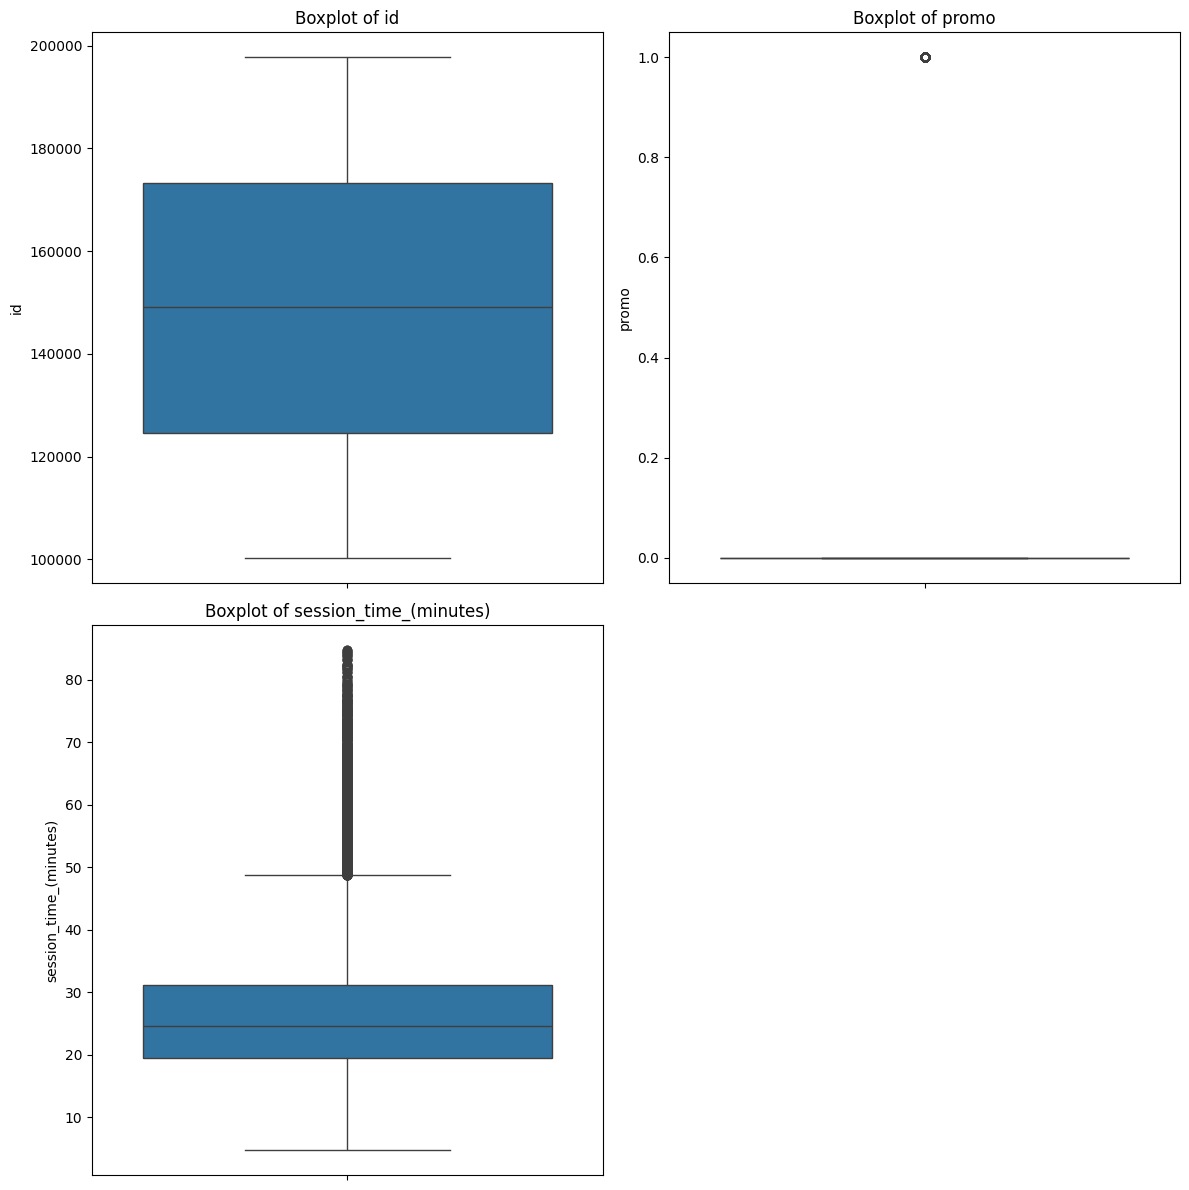

In [ ]:
cleaned_df = clean_data_with_threshold(cleaned_df, "session_time_(minutes)", 200, "above")

###### Нужно ли убирать долгие поездки?

# Общий вывод по проделанной работе на спринт с 01 по 06 апреля
Проведен детальный анализ двух датасетов:  
- rides.csv (данные о поездках):  
  - Обнаружены аномалии в дистанции (Distance) и времени сессии (Session Time).  
  - Выявлены полные дубликаты (4,831) и пропуски (555) в датах окончания поездок.  
  - Категориальные признаки (районы, локации) требуют стандартизации.  
- weather.csv (погодные данные):  
  - Данные хранятся в неоптимальном формате (единицы измерения в ячейках, строковые числа).
  - Проведена очистка и преобразование типов.
  - Проведено заполение пропусков путём интерполяции

Работа сделала основу для дальнейшего углубленного исследования. 🚀